In [5]:
from ic.client import Client
from ic.identity import Identity
from ic.agent import Agent
from ic.candid import encode, Types
from meta.peaks_env import CryptoTradingEnv
from utils.fetch_data_with_indicators import Api, fetch_data_with_indicators
import numpy as np
import pandas as pd
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import quantstats as qs
from utils.charts.plot_data_with_rsi import plot_data_with_rsi
from scipy.signal import find_peaks
from simulations.BuySellSimulation import BuySellInParts
from simulations.DCAStrategyAveraging import DCAStrategy
from simulations.BetterBuySellSimulation import BuySellWithEma
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import quantstats as qs
import onnxruntime as ort
import time

model_name = 'PPO_PARTIAL_LSTM_64_1_peaks_with_fee'

In [6]:
def run_trading_session(initial_balance, strategy_class, risk_level='medium'):
    # Data setup
    test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-05-01', '2024-11-01', '1d', ['RSI', 'EMA_50'])
    test_data = test_data.copy()
    test_data['Pct Change'] = test_data['Close'].pct_change() * 100
    test_data.dropna(inplace=True)
    peaks, properties = find_peaks(test_data['Close'], height=100, prominence=5, distance=40)
    test_data['Peak'] = 0
    test_data.loc[test_data.index[peaks], 'Peak'] = 1

    portfolio = strategy_class(initial_balance, risk_level)

    # Environment setup    
    eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
    
    obs = eval_env.reset()
    done = False
    
    # Load ONNX model
    session = ort.InferenceSession(f"onnx_exports/{model_name}.onnx")
    
    # Initialize tracking variables
    prices = []
    portfolio_values = []
    actions = []
    transactions = []
    buys = []
    sells = []
    crypto_balances = [0]
    cash_balances = [initial_balance]
    
    strategy_name = strategy_class.__name__.replace('Strategy', '')
    
    # Setup visualization
    fig = make_subplots(rows=3, cols=1, 
                       row_heights=[0.7, 0.4, 0.3],
                       specs=[[{"type": "scatter"}],
                             [{"type": "scatter"}],
                             [{"type": "bar"}]],
                       vertical_spacing=0.2)

    fig.add_trace(
        go.Scatter(x=[], y=[], name="Price", line=dict(color="blue", width=1)),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=[], y=[], name="Portfolio Value", line=dict(color="green", width=1)),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Bar(x=['Crypto', 'Cash'], y=[0, 0], name="Portfolio"),
        row=3, col=1
    )

    fig.update_layout(
        height=1400,
        showlegend=True,
        xaxis_rangeslider_visible=True,
        hovermode='x unified',
        title_text=f"Trading Session Visualization - {strategy_name}"
    )

    k = 0
    action_zones = []
    current_zone_start = 0
    current_zone_type = None
    window_size = 30

    while not done:   
        ort_inputs = {
            'prices': obs['prices'].astype(np.float32),
            'portfolio': obs['portfolio'].astype(np.float32)
        }
        
        ort_outputs = session.run(None, ort_inputs)
        onnx_action_logits, onnx_value = ort_outputs
        action = np.argmax(onnx_action_logits, axis=1)
        
        # Get current state
        current_price = eval_env.env_method('current_price')[0]
        current_step = eval_env.get_attr('current_step')[0]
        
        traded_crypto = portfolio.interpret_action(action, current_price, current_step)
        
        # Update portfolio tracking
        total_value = portfolio.balance + (portfolio.crypto_held * current_price)
        portfolio_values.append(total_value)
        prices.append(current_price)
        actions.append(action)
        transactions.append(portfolio.transaction_history[-1])
        
        time.sleep(0.2)  # Add delay for visualization
        
        # Update balances
        current_transaction = transactions[-1]
        crypto_value = current_transaction.get('crypto_held', 0) * current_price
        cash_balance = current_transaction.get('balance', 0)
        crypto_balances.append(crypto_value)
        cash_balances.append(cash_balance)
       
        # Track action zones
        action_type = 'buy' if action == 1 else 'sell' if action == 2 else 'hold'
        
        if current_zone_type != action_type:
            if current_zone_type is not None:
                action_zones.append((current_zone_start, k, current_zone_type))
            current_zone_start = k
            current_zone_type = action_type
            
        if traded_crypto > 0:
            if action == 1:
                buys.append(k)
            elif action == 2:
                sells.append(k)

        # Step environment
        obs, rewards, done, info = eval_env.step([action])
        k = k + 1
        
        # Update visualization
        with fig.batch_update():
            fig.data = fig.data[:3]
            
            fig.data[0].x = list(range(len(prices)))
            fig.data[0].y = prices
            
            fig.data[1].x = list(range(len(portfolio_values)))
            fig.data[1].y = portfolio_values
            
            if k > window_size:
                visible_idx = k - window_size
            else:
                visible_idx = k
                
            fig.data[2].x = ['Crypto', 'Cash']
            fig.data[2].y = [crypto_balances[-1], cash_balances[-1]]
            
            shapes = []
            for zone_start, zone_end, zone_type in action_zones:
                color = 'green' if zone_type == 'buy' else 'red' if zone_type == 'sell' else 'gray'
                shapes.append(dict(
                    type="rect",
                    x0=zone_start-0.5,
                    x1=zone_end-0.5,
                    y0=min(prices),
                    y1=max(prices),
                    fillcolor=color,
                    opacity=0.1,
                    layer="below",
                    xref='x',
                    yref='y'
                ))
            
            if current_zone_type is not None:
                color = 'green' if current_zone_type == 'buy' else 'red' if current_zone_type == 'sell' else 'gray'
                shapes.append(dict(
                    type="rect",
                    x0=current_zone_start-0.5,
                    x1=k-0.5,
                    y0=min(prices),
                    y1=max(prices),
                    fillcolor=color,
                    opacity=0.1,
                    layer="below",
                    xref='x',
                    yref='y'
                ))
            
            fig.update_layout(shapes=shapes)
            
            if buys:
                fig.add_trace(
                    go.Scatter(
                        x=buys, 
                        y=[prices[i] for i in buys], 
                        mode='markers+text',
                        marker=dict(symbol='triangle-up', size=15, color='green'),
                        text=[f"Buy\n${transactions[i].get('trade_amount', 0):.1f}" for i in buys],
                        textposition="top center",
                        showlegend=False, 
                        hovertemplate="Buy<br>" +
                            "Price: $%{y:,.2f}<br>" +
                            "Amount: $%{customdata[0]:.2f}<br>" +
                            "Crypto: %{customdata[1]:.8f}<extra></extra>",
                        customdata=[[transactions[i].get('trade_amount', 0), 
                                   transactions[i].get('traded_crypto', 0)] for i in buys]
                    ),
                    row=1, col=1
                )
            
            if sells:
                fig.add_trace(
                    go.Scatter(
                        x=sells, 
                        y=[prices[i] for i in sells], 
                        mode='markers+text',
                        marker=dict(symbol='triangle-down', size=15, color='red'),
                        text=[f"Sell\n${transactions[i].get('trade_amount', 0):.1f}" for i in sells],
                        textposition="bottom center",
                        showlegend=False,  
                        hovertemplate="Sell<br>" +
                            "Price: $%{y:,.2f}<br>" +
                            "Amount: $%{customdata[0]:.2f}<br>" +
                            "Crypto: %{customdata[1]:.8f}<extra></extra>",
                        customdata=[[transactions[i].get('trade_amount', 0), 
                                   transactions[i].get('traded_crypto', 0)] for i in sells]
                    ),
                    row=1, col=1
                )

            fig.update_yaxes(title_text="Price", row=1, col=1)
            fig.update_yaxes(title_text="Portfolio Value", row=2, col=1)
            fig.update_yaxes(title_text="Amount ($)", row=3, col=1)

            if k > window_size:
                fig.update_xaxes(range=[k-window_size, k], row=1, col=1)
                fig.update_xaxes(range=[k-window_size, k], row=2, col=1)
                
        clear_output(wait=True)
        display(fig)
        
    return {
        'portfolio_values': portfolio_values,
        'prices': prices,
        'actions': actions,
        'transactions': transactions,
        'crypto_balances': crypto_balances,
        'cash_balances': cash_balances
    }

def generate_performance_report(results):
    portfolio_series = pd.Series(results['portfolio_values'])
    portfolio_series.index = pd.date_range(start='2024-05-01', periods=len(portfolio_series), freq='1H')
    returns = portfolio_series.pct_change().fillna(0)
    
    qs.reports.basic(returns, title='Trading Strategy Performance Report')

In [7]:
initial_balance = 1000.0
risk_level = 'medium'

BuySellInParts Strategy - Final Portfolio Value: $1180.69
BuySellInParts Strategy - Total Transactions: 124


/tmp/ipykernel_63826/333491979.py:236: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



                    Strategy
------------------  ----------
Start Period        2024-05-01
End Period          2024-05-06
Risk-Free Rate      0.0%
Time in Market      93.0%

Cumulative Return   18.07%
CAGR﹪              432111.72%

Sharpe              1.73
Prob. Sharpe Ratio  90.17%
Sortino             3.07
Sortino/√2          2.17
Omega               1.43

Max Drawdown        -7.35%
Longest DD Days     1

Gain/Pain Ratio     15.48
Gain/Pain (1M)      -

Payoff Ratio        1.4
Profit Factor       1.43
Common Sense Ratio  1.7
CPC Index           1.01
Tail Ratio          1.19
Outlier Win Ratio   4.19
Outlier Loss Ratio  3.07

MTD                 18.07%
3M                  18.07%
6M                  18.07%
YTD                 18.07%
1Y                  18.07%
3Y (ann.)           432111.72%
5Y (ann.)           432111.72%
10Y (ann.)          432111.72%
All-time (ann.)     432111.72%

Avg. Drawdown       -1.87%
Avg. Drawdown Days  1
Recovery Factor     2.4
Ulcer Index         0.02
Serenity 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


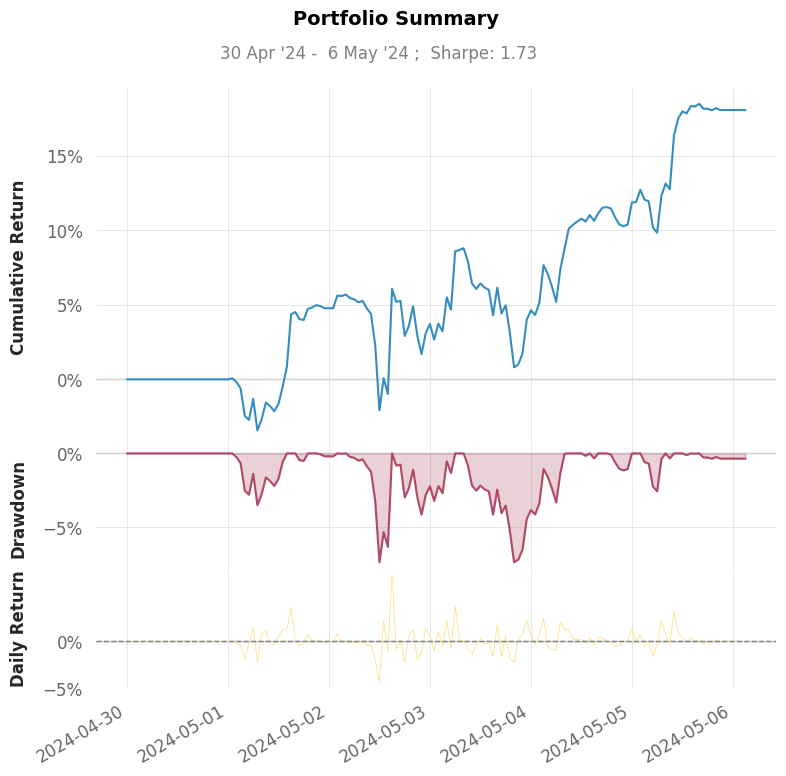

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


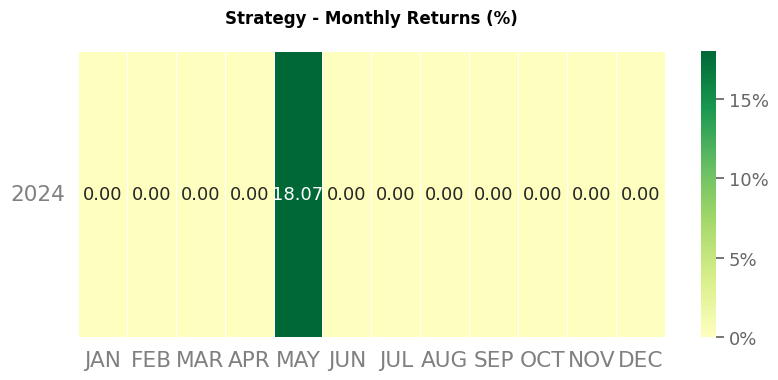

In [8]:

print("Running BuySellInParts Strategy...")
results_buy_sell = run_trading_session(initial_balance, BuySellInParts, risk_level)
print(f"BuySellInParts Strategy - Final Portfolio Value: ${results_buy_sell['portfolio_values'][-1]:.2f}")
generate_performance_report(results_buy_sell)

BuySellWithEma Strategy - Final Portfolio Value: $1337.86
BuySellWithEma Strategy - Total Transactions: 124


/tmp/ipykernel_63826/333491979.py:236: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



                    Strategy
------------------  -------------
Start Period        2024-05-01
End Period          2024-05-06
Risk-Free Rate      0.0%
Time in Market      63.0%

Cumulative Return   33.79%
CAGR﹪              234992990.77%

Sharpe              2.29
Prob. Sharpe Ratio  96.41%
Sortino             4.47
Sortino/√2          3.16
Omega               1.68

Max Drawdown        -7.24%
Longest DD Days     1

Gain/Pain Ratio     -
Gain/Pain (1M)      -

Payoff Ratio        1.4
Profit Factor       1.68
Common Sense Ratio  2.17
CPC Index           1.29
Tail Ratio          1.29
Outlier Win Ratio   6.35
Outlier Loss Ratio  2.48

MTD                 33.79%
3M                  33.79%
6M                  33.79%
YTD                 33.79%
1Y                  33.79%
3Y (ann.)           234992990.77%
5Y (ann.)           234992990.77%
10Y (ann.)          234992990.77%
All-time (ann.)     234992990.77%

Avg. Drawdown       -3.45%
Avg. Drawdown Days  1
Recovery Factor     4.27
Ulcer Index       

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


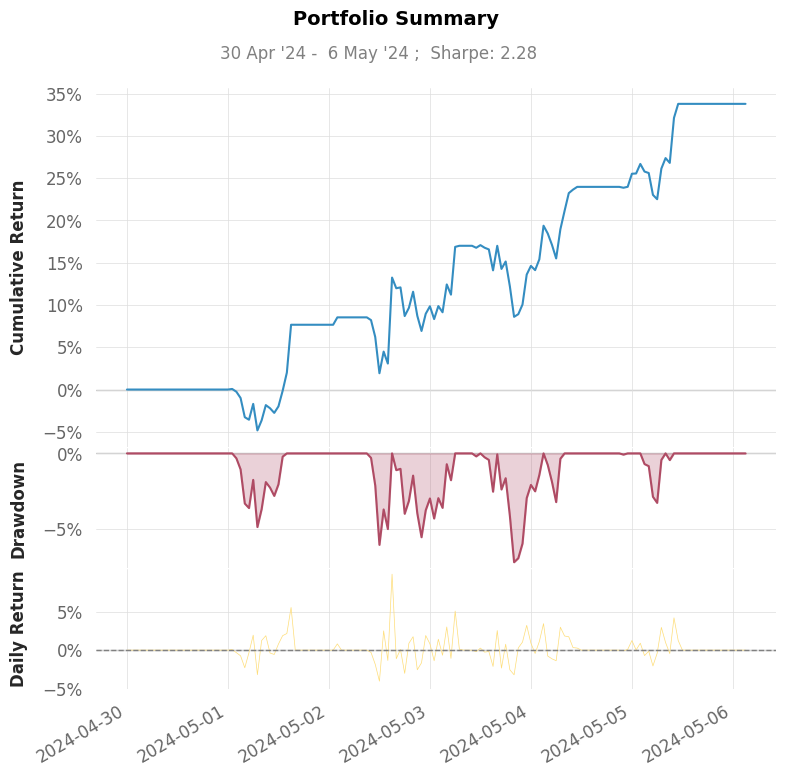

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


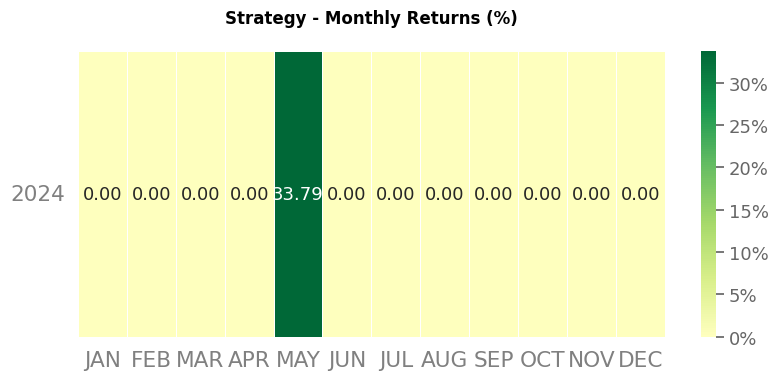

In [9]:
print("Running BuySellWithEma Strategy...")
results_buy_sell_ema = run_trading_session(initial_balance, BuySellWithEma, risk_level)
print(f"BuySellWithEma Strategy - Final Portfolio Value: ${results_buy_sell_ema['portfolio_values'][-1]:.2f}")
generate_performance_report(results_buy_sell_ema)

DCAStrategy - Final Portfolio Value: $1138.51
DCAStrategy - Total Transactions: 124


/tmp/ipykernel_63826/333491979.py:236: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



                    Strategy
------------------  ----------
Start Period        2024-05-01
End Period          2024-05-06
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   13.85%
CAGR﹪              68988.61%

Sharpe              1.44
Prob. Sharpe Ratio  84.84%
Sortino             2.36
Sortino/√2          1.67
Omega               1.3

Max Drawdown        -8.27%
Longest DD Days     2

Gain/Pain Ratio     3.19
Gain/Pain (1M)      -

Payoff Ratio        1.24
Profit Factor       1.3
Common Sense Ratio  1.65
CPC Index           0.82
Tail Ratio          1.27
Outlier Win Ratio   3.62
Outlier Loss Ratio  3.27

MTD                 13.85%
3M                  13.85%
6M                  13.85%
YTD                 13.85%
1Y                  13.85%
3Y (ann.)           68988.61%
5Y (ann.)           68988.61%
10Y (ann.)          68988.61%
All-time (ann.)     68988.61%

Avg. Drawdown       -2.31%
Avg. Drawdown Days  1
Recovery Factor     1.68
Ulcer Index         0.03
Serenity Inde

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


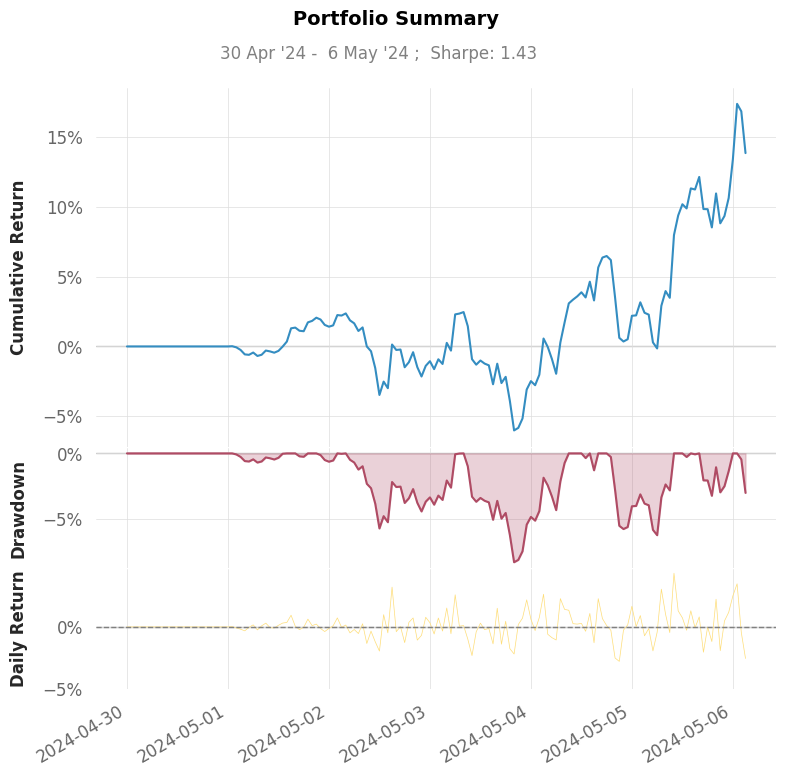

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


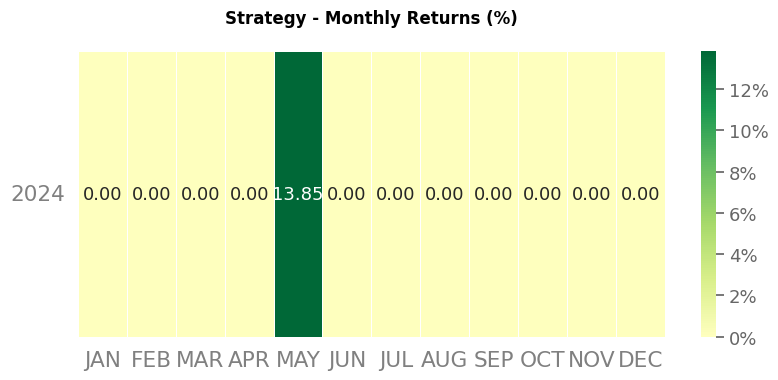

In [10]:
print("\nRunning DCAStrategy...")
results_dca = run_trading_session(initial_balance, DCAStrategy, risk_level)
print(f"DCAStrategy - Final Portfolio Value: ${results_dca['portfolio_values'][-1]:.2f}")
generate_performance_report(results_dca)